# How to Export a Segment Anything 2 model fine-tuned in Supervisely

After you have fine-tuned a Segment Anything 2 model using corresponding app, you can download the best checkpoint from Team Files and use your trained SAM 2 model outside Supervisely Platform.

## 1. Download checkpoint from Team Files

Click on "More features" icon in the left sidebar:

![sam3_outside_sly_0](https://github.com/user-attachments/assets/aa7b815f-c476-4eed-b0ca-5724a073601e)

Open Team Files:

![sam3_outside_sly_1](https://github.com/user-attachments/assets/e8442fab-e649-49ee-af31-349544c5914f)

Go to experiments folder, select dataset, select app session, right click on fine-tuned model checkpoints and click on "Download" option:

![sam3_outside_sly_2](https://github.com/user-attachments/assets/2ec73a55-ae2d-4049-92c9-be3a5c066e4e)

Alternatively, you can download these files using Supervisely API:

In [ ]:
# install supervisely SDK if not installed
!pip install supervisely

To download files via Supervisely API, you will need to define [server address](https://developer.supervisely.com/getting-started/basics-of-authentication#server_address-env), [api token](https://developer.supervisely.com/getting-started/basics-of-authentication#api_token-env) and [team ID](https://developer.supervisely.com/getting-started/environment-variables#team_id):

In [ ]:
import supervisely as sly
import os


server_address = "your_server_adress"
api_token = "your_api_token"
team_id = "your_team_id"
path_to_weights_in_team_files = "path_to_your_checkpoint"
download_dir = "./my_model"

api = sly.Api(server_address, api_token)
local_weights_path = os.path.join(download_dir, "checkpoint.pt")
api.file.download(team_id, path_to_weights_in_team_files, local_weights_path)

## 2. Install necessary libraries

You can use [official SAM 3 installation guide](https://github.com/facebookresearch/sam3/tree/5eb25fb54b70ec0cb16f949289053be091e16705?tab=readme-ov-file#installation) to install necessary dependencies.

## 3. Load fine-tuned model and input image

In [3]:
# import necessary libraires
from sam3.model_builder import build_sam3_image_model
from sam3.train.utils.checkpoint_utils import load_state_dict_into_model
import torch
from PIL import Image
from sam3.model.sam3_image_processor import Sam3Processor
import sam3.model.box_ops as box_ops
from sam3.visualization_utils import normalize_bbox
import supervisely as sly
import numpy as np
import matplotlib.pyplot as plt


# set image display parameters
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

In [4]:
# load fine-tuned model
checkpoint_path = "your_checkpoint_path"
bpe_path = "sam3/assets/bpe_simple_vocab_16e6.txt.gz" # or your custom path

checkpoint = torch.load(checkpoint_path)
enable_inst_interactivity = checkpoint.get("enable_instance_interactivity", False)
model = build_sam3_image_model(
    bpe_path=bpe_path,
    load_from_HF=False,
    enable_inst_interactivity=enable_inst_interactivity,
)
model = load_state_dict_into_model(model=model, state_dict=checkpoint["model"])
processor = Sam3Processor(model)

In [5]:
# load input image
image_path = "your_image_path"
image = Image.open(image_path)
width, height = image.width, image.height

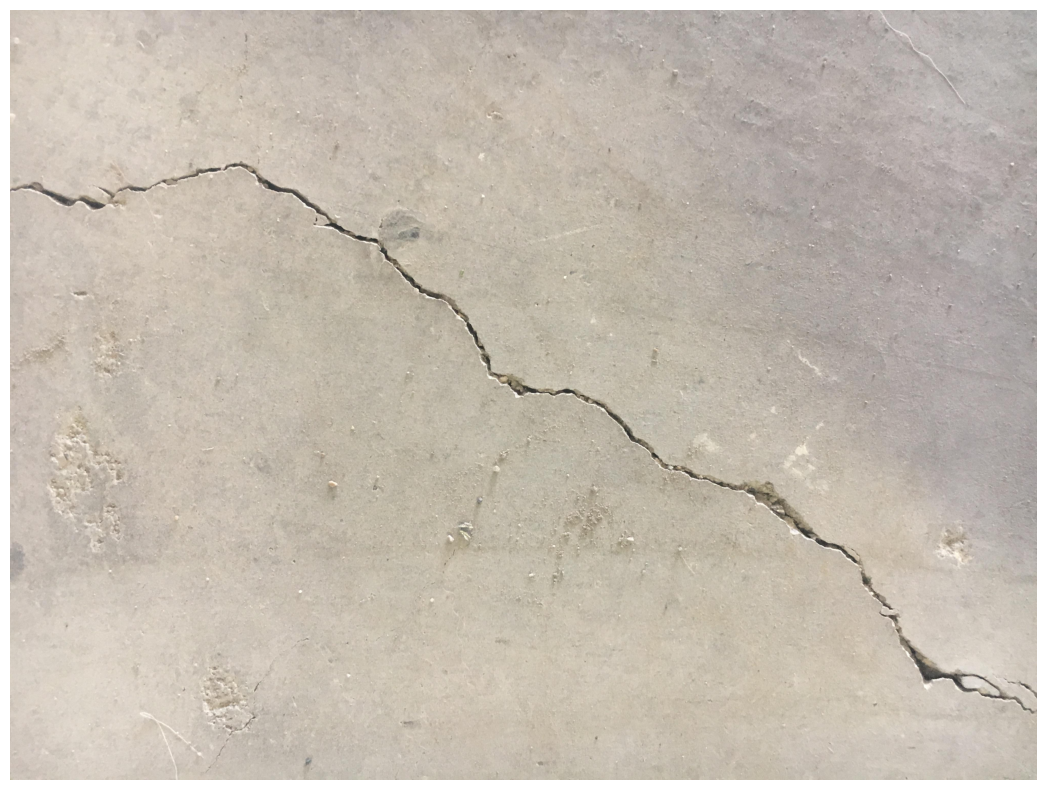

In [6]:
# visualize image
plt.axis("off")
plt.imshow(image);

## 4. Inference

In [7]:
inference_state = processor.set_image(image)

### Text prompt

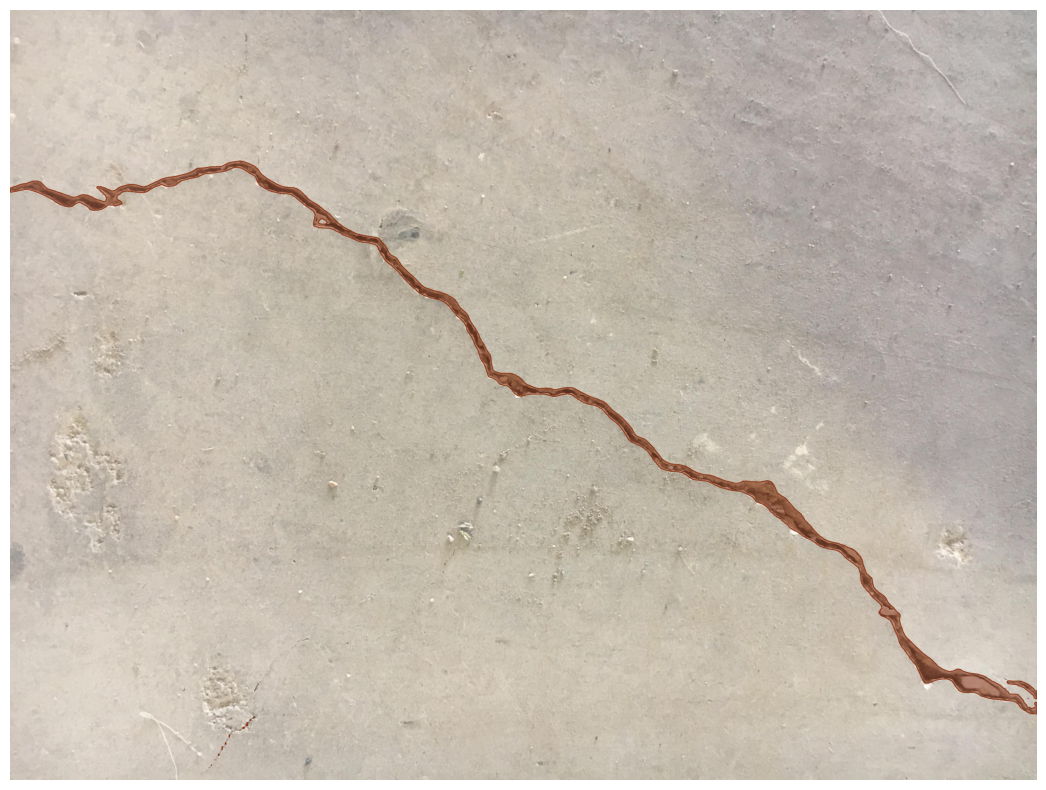

In [8]:
# define input prompt
text_prompt = "crack"

# run inference
inference_state = processor.set_text_prompt(
    state=inference_state, prompt=text_prompt
)
results = inference_state
scores, masks, boxes = (
    results["scores"].cpu(),
    results["masks"].squeeze(0).cpu(),
    results["boxes"].cpu(),
)

# visualize model predictions
obj_class = sly.ObjClass("object", sly.Bitmap)
geometry = sly.Bitmap(masks[0].numpy(), extra_validation=False)
label = sly.Label(geometry, obj_class)
ann = sly.Annotation((height, width), [label])

viz_img = np.array(image).copy()
ann.draw_pretty(
    bitmap=viz_img,
    thickness=2,
    output_path="inference_text.png",
)

viz_img = Image.fromarray(viz_img)
plt.axis("off")
plt.imshow(viz_img);

### Visual prompt

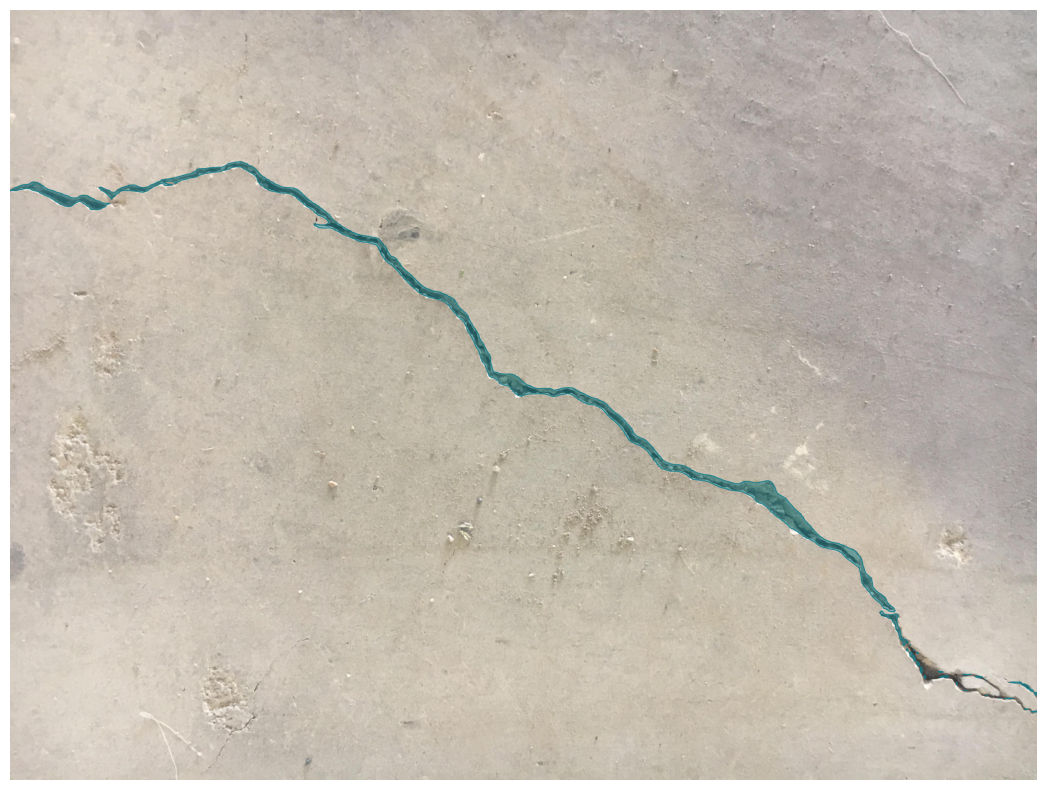

In [17]:
# clear previous prompt
processor.reset_all_prompts(inference_state)

# define input prompt
box = [0, 592, 4031, 2175]
box = box_ops.box_xyxy_to_cxcywh(torch.tensor([box]))
box = normalize_bbox(box, width, height).tolist()

# run inference
inference_state = processor.add_geometric_prompt(
    state=inference_state, box=box[0], label=True
)
results = inference_state
scores, masks, boxes = (
    results["scores"].cpu(),
    results["masks"].squeeze(0).cpu(),
    results["boxes"].cpu(),
)


obj_class = sly.ObjClass("object", sly.Bitmap)
geometry = sly.Bitmap(masks[0].numpy(), extra_validation=False)
label = sly.Label(geometry, obj_class)
ann = sly.Annotation((height, width), [label])

viz_img = np.array(image).copy()
ann.draw_pretty(
    bitmap=viz_img,
    thickness=2,
    output_path="inference_visual.png",
)

viz_img = Image.fromarray(viz_img)
plt.axis("off")
plt.imshow(viz_img);

### Interactive prompt

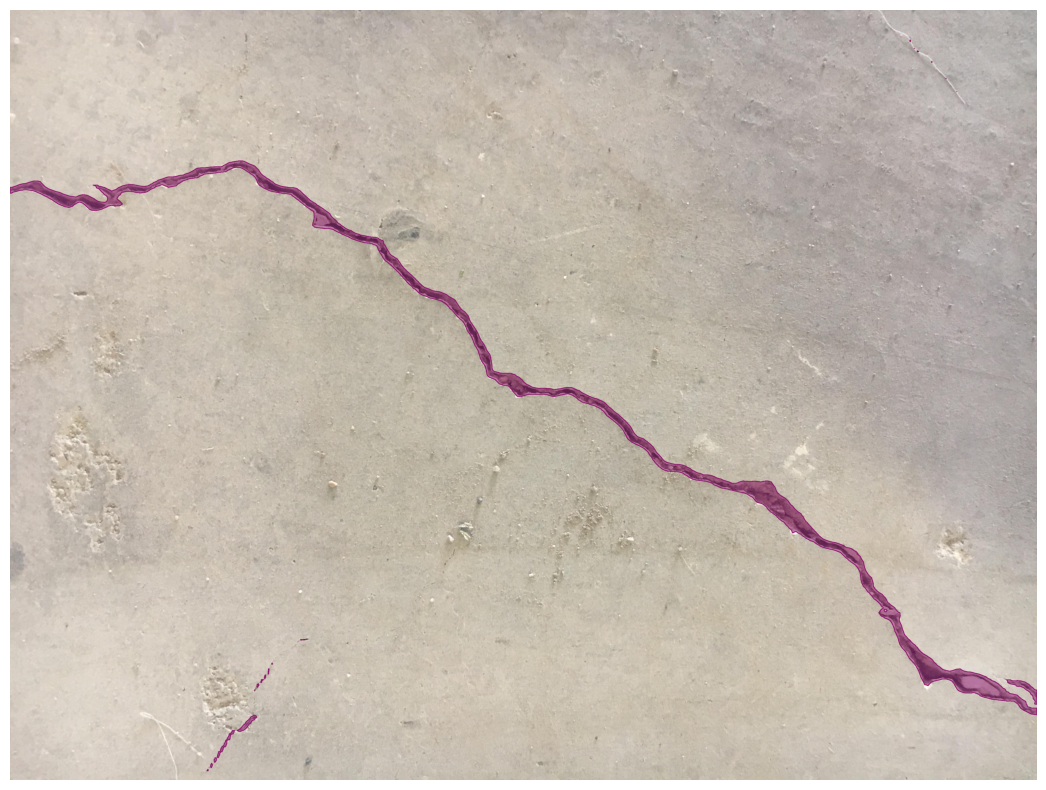

In [15]:
# define input prompt
point_coordinates = np.array([[3454, 2372], [3679, 2616], [2465, 1699]])
point_labels = np.array([1, 1, 1])

# run inference
masks, scores, logits = model.predict_inst(
    inference_state,
    point_coords=point_coordinates,
    point_labels=point_labels,
    multimask_output=False,
)

# visualize model predictions
obj_class = sly.ObjClass("object", sly.Bitmap)
geometry = sly.Bitmap(masks[0], extra_validation=False)
label = sly.Label(geometry, obj_class)
ann = sly.Annotation((height, width), [label])

viz_img = np.array(image).copy()
ann.draw_pretty(
    bitmap=viz_img,
    thickness=2,
    output_path="inference_interactive.png",
)

viz_img = Image.fromarray(viz_img)
plt.axis("off")
plt.imshow(viz_img);